# Human Parts Detection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from ultralytics import YOLO
import wandb

## Dataset Processing and Analysis

In [5]:
original_dataset_folder = 'datasets/original_dataset/'
sub_folders = os.listdir(original_dataset_folder)
sub_folders = [os.path.join(original_dataset_folder, sub_folder) for sub_folder in sub_folders]

In [7]:
# traverse each subfolder. the images have some <id>.jpg while masks have <id>_m.png
all_image_paths = []
all_masks_paths = []
for sub_folder in sub_folders:
    images = [os.path.join(sub_folder, image) for image in os.listdir(sub_folder) if image.endswith('.jpg')]
    masks = [os.path.join(sub_folder, mask) for mask in os.listdir(sub_folder) if mask.endswith('_m.png')]
    all_image_paths.extend(images)
    all_masks_paths.extend(masks)
    
# sort the images and masks
all_image_paths.sort()
all_masks_paths.sort()

len(all_image_paths), len(all_masks_paths)

(3961, 3961)

In [16]:
# get unique classes
unique_classes = set()
for mask_path in all_masks_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    unique_classes.update(np.unique(mask))
unique_classes = list(unique_classes)
unique_classes.sort()

num_classes = len(unique_classes)
num_classes

8

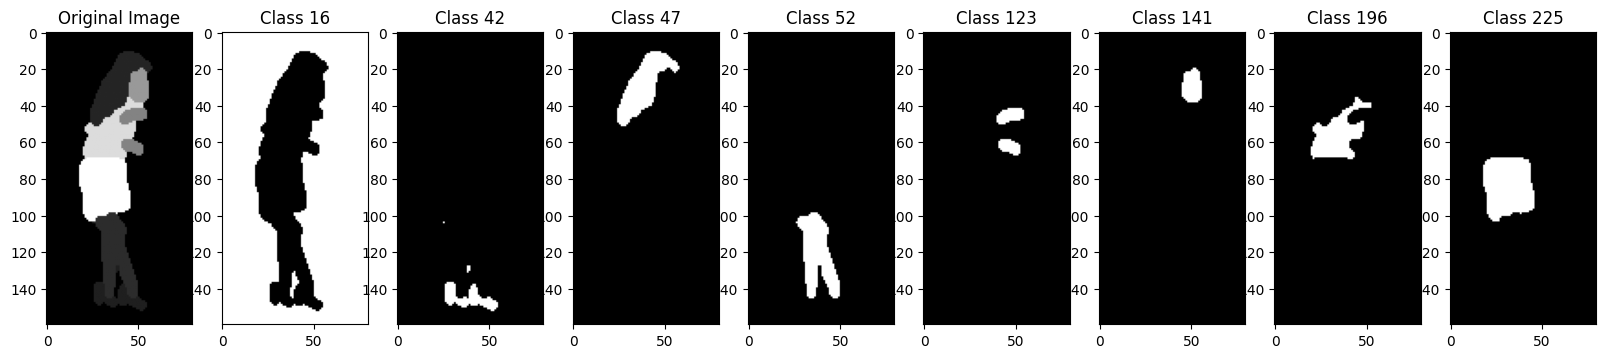

In [17]:
# see the classes in an image to get class and color mapping
image = cv2.imread('datasets/original_dataset/14/0424_4_m.png', cv2.IMREAD_GRAYSCALE)

# show original image along with each part separately
fig, axs = plt.subplots(1, num_classes + 1, figsize=(20, 5))
axs[0].imshow(image, cmap='gray')
axs[0].set_title('Original Image')
for i, class_id in enumerate(unique_classes):
    mask = (image == class_id).astype(np.uint8)
    axs[i + 1].imshow(mask, cmap='gray')
    axs[i + 1].set_title(f'Class {class_id}')
plt.show()

In [20]:
# ignore background
class_names = ['shoe', 'hair', 'legs', 'hands', 'face', 'topwear', 'bottomwear']
unique_colours = unique_classes[1:]
idx2label = {idx: label for idx, label in enumerate(class_names)}
label2idx = {label: idx for idx, label in enumerate(class_names)}
num_classes = len(class_names)
num_classes

7

In [38]:
def mask_to_bounding_box(mask):
    """
    Get the bounding box of the mask
    """
    annots = []
    for class_id in range(num_classes):
        mask_class = np.zeros_like(mask)
        mask_class[mask == unique_colours[class_id]] = 255
        img_height, img_width = mask_class.shape
        contours, _ = cv2.findContours(mask_class, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            xc = x + w/2
            yc = y + h/2
            xc, yc, w, h = xc/img_width, yc/img_height, w/img_width, h/img_height
            annots.append((class_id, xc, yc, w, h))
    return annots

In [42]:
# split into train and val
val_indices = np.random.choice(len(all_image_paths), int(0.2 * len(all_image_paths)), replace=False)
train_image_paths = [all_image_paths[i] for i in range(len(all_image_paths)) if i not in val_indices]
train_masks_paths = [all_masks_paths[i] for i in range(len(all_image_paths)) if i not in val_indices]
val_image_paths = [all_image_paths[i] for i in val_indices]
val_masks_paths = [all_masks_paths[i] for i in val_indices]

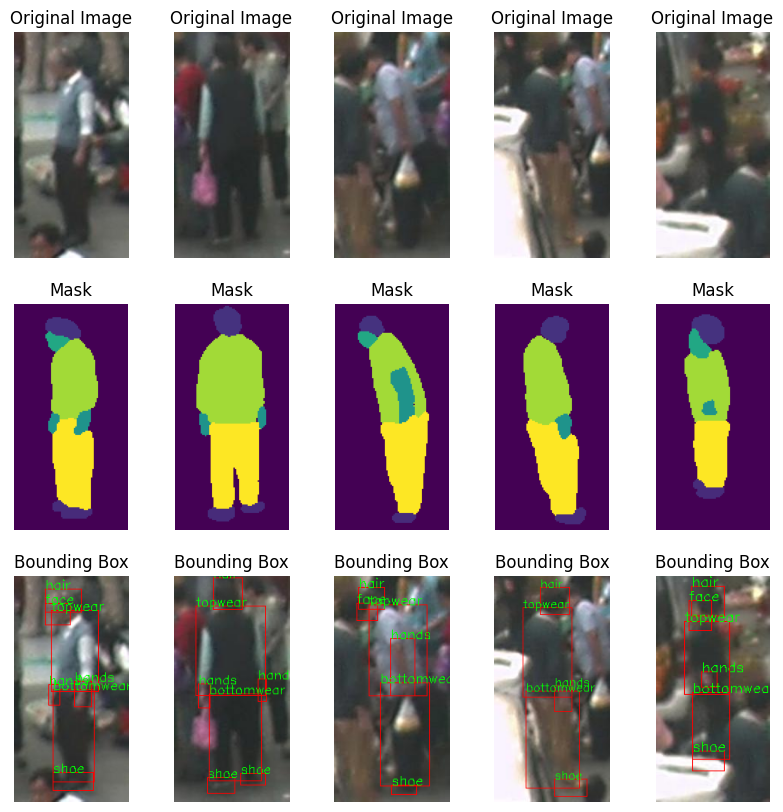

In [43]:
# show some sample images
fig, axs = plt.subplots(3, 5, figsize=(10, 10))
for i in range(5):
    image = cv2.imread(train_image_paths[i], cv2.IMREAD_COLOR)
    mask = cv2.imread(train_masks_paths[i], cv2.IMREAD_GRAYSCALE)
    axs[0, i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0, i].set_title('Original Image')
    axs[0, i].axis('off')
    axs[1, i].imshow(mask)
    axs[1, i].set_title('Mask')
    axs[1, i].axis('off')
    annots = mask_to_bounding_box(mask)
    img_annots = image.copy()
    for class_id, xc, yc, w, h in annots:
        x, y = int((xc - w/2) * image.shape[1]), int((yc - h/2) * image.shape[0])
        x2, y2 = int((xc + w/2) * image.shape[1]), int((yc + h/2) * image.shape[0])
        cv2.rectangle(img_annots, (x, y), (x2, y2), (0, 0, 255), 1)
        cv2.putText(img_annots, idx2label[class_id], (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    axs[2, i].imshow(cv2.cvtColor(img_annots, cv2.COLOR_BGR2RGB))
    axs[2, i].set_title('Bounding Box')
    axs[2, i].axis('off')
plt.show()

- To get unique human parts, a set is used. Iterating over all the masks, converting them to gray-scale and adding the unique colors to the set.
- To get the bounding boxes, a separate mask is obtained for each human part and then the contours are found using `cv2.findContours`. The bounding box is then calculated using `cv2.boundingRect`.
- The annotations are stored in a list of tuples, with each element of the tuple containing the class id and the bounding box coordinates (xc, yc, w, h).
- 20% of the dataset is used for validation and the rest for training.

/tmp/ipykernel_14303/2550682303.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names)


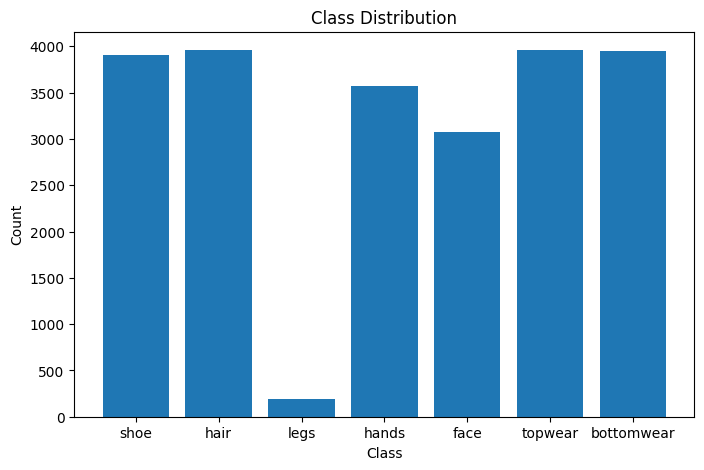

In [48]:
# distribution of number of classes
class_counts = np.zeros(num_classes)
for mask_path in all_masks_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    for class_id in range(num_classes):
        if np.sum(mask == unique_colours[class_id]) > 0:
            class_counts[class_id] += 1

# make a bar chart of class distributions
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(class_names, class_counts)
ax.set_title('Class Distribution')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticklabels(class_names)
plt.show()

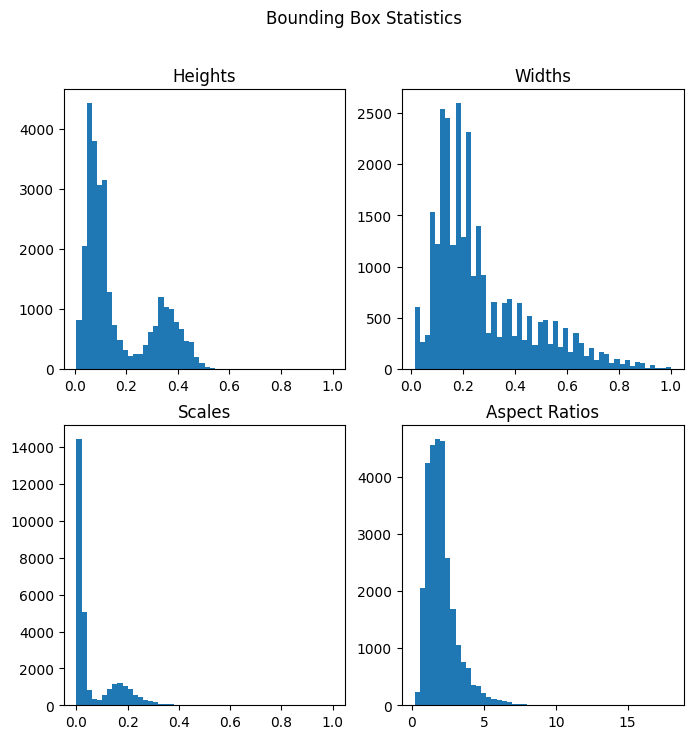

In [51]:
# variations in scale, aspect ratio and positioning of part annotations
# get the bounding box statistics
heights = []
widths = []
scales = []
aspect_ratios = []

for mask_path in all_masks_paths:
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    annots = mask_to_bounding_box(mask)
    for class_id, xc, yc, w, h in annots:
        heights.append(h)
        widths.append(w)
        scales.append(h * w)
        aspect_ratios.append(w / h)
        
# plot the statistics
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs[0, 0].hist(heights, bins=50)
axs[0, 0].set_title('Heights')
axs[0, 1].hist(widths, bins=50)
axs[0, 1].set_title('Widths')
axs[1, 0].hist(scales, bins=50)
axs[1, 0].set_title('Scales')
axs[1, 1].hist(aspect_ratios, bins=50)
axs[1, 1].set_title('Aspect Ratios')
plt.suptitle('Bounding Box Statistics')
plt.show()

Observations:
- Legs have significantly fewer samples -> Possible dataset imbalance that may impact model performance.
- Scales are heavily skewed towards smaller values -> Most bounding boxes cover a small fraction of the image.
- Aspect ratios are mostly near 1 but have a long tail -> Many bounding boxes are close to square, but some are significantly elongated with more width.

## Preparing Dataset

In [52]:
# prepare the dataset for yolov8 by storing images and annotations in a folder
processed_dataset_folder = 'datasets/processed_dataset/'
os.makedirs(processed_dataset_folder, exist_ok=True)
os.makedirs(os.path.join(processed_dataset_folder, 'images'), exist_ok=True)
os.makedirs(os.path.join(processed_dataset_folder, 'labels'), exist_ok=True)

# make train and val folders
os.makedirs(os.path.join(processed_dataset_folder, 'images', 'train'), exist_ok=True)
os.makedirs(os.path.join(processed_dataset_folder, 'labels', 'train'), exist_ok=True)
os.makedirs(os.path.join(processed_dataset_folder, 'images', 'val'), exist_ok=True)
os.makedirs(os.path.join(processed_dataset_folder, 'labels', 'val'), exist_ok=True)

In [53]:
# fill in train images and labels
for i, (image_path, mask_path) in enumerate(zip(train_image_paths, train_masks_paths)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    annots = mask_to_bounding_box(mask)
    height, width, _ = image.shape
    with open(os.path.join(processed_dataset_folder, 'labels', 'train', f'{i}.txt'), 'w') as f:
        for class_id, xc, yc, w, h in annots:
            f.write(f'{class_id} {xc} {yc} {w} {h}\n')
    cv2.imwrite(os.path.join(processed_dataset_folder, 'images', 'train', f'{i}.jpg'), image)
    
# fill in val images and labels
for i, (image_path, mask_path) in enumerate(zip(val_image_paths, val_masks_paths)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    annots = mask_to_bounding_box(mask)
    height, width, _ = image.shape
    with open(os.path.join(processed_dataset_folder, 'labels', 'val', f'{i}.txt'), 'w') as f:
        for class_id, xc, yc, w, h in annots:
            f.write(f'{class_id} {xc} {yc} {w} {h}\n')
    cv2.imwrite(os.path.join(processed_dataset_folder, 'images', 'val', f'{i}.jpg'), image)

In [54]:
# prepare dataset.yaml file
dataset_yaml = f"""
train: images/train
val: images/val

nc: {num_classes}
names: {class_names}
"""
with open(os.path.join(processed_dataset_folder, 'dataset.yaml'), 'w') as f:
    f.write(dataset_yaml)

## Model

Reasons for choosing YOLOv8:
- YOLOv8 is a state-of-the-art object detection model that is known for its good tradeoff between speed and accuracy.
- It is a single-stage detector that can detect multiple objects in a single forward pass. Makes it faster than two-stage detectors like Faster R-CNN.
- Human parts like hands and shoes are small and YOLOv8 is known to perform well on small objects.
- YOLOv8 is easy to implement and train.
- Allows for easy data augmentation.
  
For data augmentation the following transformations are used:
`mosaic=1.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=10, translate=0.1, scale=0.5, shear=2.0, flipud=0.5, fliplr=0.5` which can directly be passed as arguments to train function.

Dataset preparation has been done and stored in `datasets/processed_dataset/` folder.

There is no need for any anchor box calculation as YOLOv8 uses a grid-based approach for object detection. 

In [2]:
wandb.init(project="yolo-human-parts-detection")
data_yaml = "/home/gaurav/Documents/assignment-3-gaurav-behera/q3/datasets/processed_dataset/dataset.yaml"

model = YOLO("yolo_files/yolov8n.pt", task='detect')

wandb: Currently logged in as: gauravbehera (gauravbehera-iiith) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


In [3]:
model.train(
    data=data_yaml,
    epochs=20,  
    imgsz=320,  
    batch=32,  
    device="cuda",
    project="runs",  
    name="yolo_parts",
    # data augmentations
    fliplr=0.5,
    scale=0.5,
    hsv_h=0.015, 
    hsv_s=0.7,
    hsv_v=0.4,
)

Ultralytics 8.3.89 🚀 Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3090, 24150MiB)
engine/trainer: task=detect, mode=train, model=yolo_files/yolov8n.pt, data=/home/gaurav/Documents/assignment-3-gaurav-behera/q3/datasets/processed_dataset/dataset.yaml, epochs=20, time=None, patience=100, batch=32, imgsz=320, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=runs, name=yolo_parts, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fals

100%|██████████| 5.35M/5.35M [00:05<00:00, 1.07MB/s]


AMP: checks passed ✅


train: Scanning /home/gaurav/Documents/assignment-3-gaurav-behera/q3/datasets/processed_dataset/labels/train.cache... 3169 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3169/3169 [00:00<?, ?it/s]
val: Scanning /home/gaurav/Documents/assignment-3-gaurav-behera/q3/datasets/processed_dataset/labels/val.cache... 792 images, 0 backgrounds, 0 corrupt: 100%|██████████| 792/792 [00:00<?, ?it/s]


Plotting labels to runs/yolo_parts/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to runs/yolo_parts
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.06G      1.956      2.624      1.463         18        320: 100%|██████████| 100/100 [00:05<00:00, 17.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00,  9.70it/s]


                   all        792       5681       0.69      0.396      0.479      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.08G      1.713      1.202       1.28          9        320: 100%|██████████| 100/100 [00:04<00:00, 20.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.44it/s]

                   all        792       5681      0.727      0.522      0.552      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       1.1G      1.663       1.12      1.263         16        320: 100%|██████████| 100/100 [00:04<00:00, 21.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.58it/s]

                   all        792       5681       0.72      0.572      0.614       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       1.1G      1.653      1.088      1.273         11        320: 100%|██████████| 100/100 [00:04<00:00, 20.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.39it/s]


                   all        792       5681      0.696      0.614      0.625      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       1.1G      1.606      1.035      1.254          6        320: 100%|██████████| 100/100 [00:04<00:00, 21.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.57it/s]

                   all        792       5681      0.766      0.612      0.637      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.11G      1.592     0.9967      1.237         23        320: 100%|██████████| 100/100 [00:04<00:00, 21.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.60it/s]

                   all        792       5681      0.725       0.61       0.63      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.17G       1.56     0.9781      1.228          7        320: 100%|██████████| 100/100 [00:04<00:00, 21.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.49it/s]

                   all        792       5681      0.775      0.629      0.656      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.18G      1.543     0.9435      1.225         13        320: 100%|██████████| 100/100 [00:04<00:00, 21.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.65it/s]

                   all        792       5681      0.768       0.64      0.666      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.18G      1.534     0.9381      1.216         19        320: 100%|██████████| 100/100 [00:04<00:00, 21.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.59it/s]

                   all        792       5681      0.745      0.654      0.674      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.18G      1.521     0.9204       1.21         16        320: 100%|██████████| 100/100 [00:04<00:00, 21.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.61it/s]

                   all        792       5681      0.777      0.655      0.677      0.367


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.18G      1.544     0.9621      1.245          8        320: 100%|██████████| 100/100 [00:04<00:00, 20.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.48it/s]

                   all        792       5681      0.756      0.644      0.667      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.18G      1.527     0.9233      1.243          7        320: 100%|██████████| 100/100 [00:04<00:00, 21.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.34it/s]

                   all        792       5681      0.749      0.656       0.68      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.18G      1.509     0.9013      1.232          6        320: 100%|██████████| 100/100 [00:04<00:00, 21.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.55it/s]

                   all        792       5681      0.768      0.643       0.67      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.18G        1.5     0.9012      1.236          6        320: 100%|██████████| 100/100 [00:04<00:00, 21.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.26it/s]

                   all        792       5681      0.798      0.669      0.691      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.18G      1.471     0.8576      1.204          6        320: 100%|██████████| 100/100 [00:04<00:00, 21.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.64it/s]

                   all        792       5681      0.775      0.667      0.692      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.18G      1.457     0.8451      1.208          3        320: 100%|██████████| 100/100 [00:04<00:00, 21.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.53it/s]

                   all        792       5681      0.779       0.66      0.688      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.18G      1.449     0.8291      1.201          7        320: 100%|██████████| 100/100 [00:04<00:00, 21.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.25it/s]

                   all        792       5681      0.789       0.67      0.699      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.18G      1.426     0.8182      1.187          8        320: 100%|██████████| 100/100 [00:04<00:00, 21.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.69it/s]

                   all        792       5681      0.814       0.67      0.703      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.18G      1.408     0.8014      1.183          5        320: 100%|██████████| 100/100 [00:04<00:00, 21.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.71it/s]

                   all        792       5681      0.814      0.679      0.707      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.18G      1.408     0.7996      1.182          6        320: 100%|██████████| 100/100 [00:04<00:00, 21.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:01<00:00, 10.62it/s]

                   all        792       5681      0.818      0.683       0.71      0.395



20 epochs completed in 0.035 hours.
Optimizer stripped from runs/yolo_parts/weights/last.pt, 6.2MB
Optimizer stripped from runs/yolo_parts/weights/best.pt, 6.2MB

Validating runs/yolo_parts/weights/best.pt...
Ultralytics 8.3.89 🚀 Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3090, 24150MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 13/13 [00:02<00:00,  6.20it/s]


                   all        792       5681      0.818      0.683       0.71      0.395
                  shoe        781       1383      0.713       0.41      0.456      0.175
                  hair        792        798      0.863      0.883      0.906      0.516
                  legs         33         57      0.743      0.455      0.487       0.22
                 hands        716       1177       0.73      0.477      0.522      0.225
                  face        609        622      0.785      0.683      0.711      0.306
               topwear        791        836      0.961      0.936      0.941      0.685
            bottomwear        789        808      0.932      0.934      0.947       0.64
Speed: 0.0ms preprocess, 0.1ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/yolo_parts


lr/pg0,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg1,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
lr/pg2,▃▆██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
metrics/mAP50(B),▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇████
metrics/mAP50-95(B),▁▃▅▅▅▅▆▇▇▇▇▇▇▇█▇████
metrics/precision(B),▁▃▃▁▅▃▆▅▄▆▅▄▅▇▆▆▆███
metrics/recall(B),▁▄▅▆▆▆▇▇▇▇▇▇▇██▇████
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▅▄▄▄▃▃▃▃▂▃▃▂▂▂▂▂▁▁▁


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x717fa25fff50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

Training time: 2m 35s

Resource utilization: 1.2GB GPU memory

Convergence - The model converges well and the loss decreases steadily. Around 15-20 epochs are enough for the model to converge.

In [ ]:
# save the model
model.save("yolo_parts.pt")

## Evaluation and Results

In [2]:
model = YOLO("yolo_parts.pt", task='detect')
results = model.val()

Ultralytics 8.3.89 🚀 Python-3.11.11 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce RTX 3090, 24150MiB)


val: Scanning /home/gaurav/Documents/assignment-3-gaurav-behera/q3/datasets/processed_dataset/labels/val.cache... 792 images, 0 backgrounds, 0 corrupt: 100%|██████████| 792/792 [00:00<?, ?it/s]


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 50/50 [00:02<00:00, 22.05it/s]


                   all        792       5681      0.819      0.681       0.71      0.395
                  shoe        781       1383      0.714      0.408      0.455      0.175
                  hair        792        798      0.864      0.883      0.906      0.517
                  legs         33         57      0.742      0.454      0.488      0.217
                 hands        716       1177      0.737      0.473      0.521      0.225
                  face        609        622      0.784       0.68      0.711      0.306
               topwear        791        836      0.962      0.936      0.941      0.685
            bottomwear        789        808      0.932      0.934      0.947       0.64
Speed: 0.0ms preprocess, 0.6ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/val2


In [7]:
# map at different IoU thresholds
maps = results.box.maps
maps = maps[::-1]
for iou in range(len(maps)):
    print(f"mAP@{50 + 5 * iou}: {maps[iou]}")

mAP@50: 0.6399584142047342
mAP@55: 0.6852458228482475
mAP@60: 0.306356392955434
mAP@65: 0.22510164173977593
mAP@70: 0.2174419632232451
mAP@75: 0.5167819430540124
mAP@80: 0.1748896874427525


In [11]:
# part specific precision, recall and map score
class_names = model.names
precision_per_class = results.box.p
recall_per_class = results.box.r
map_per_class = results.box.maps
for class_id, class_name in class_names.items():
    print(f"Class: {class_name}")
    print(f"    Precision: {precision_per_class[class_id]}")
    print(f"    Recall: {recall_per_class[class_id]}")
    print(f"    mAP: {map_per_class[class_id]}")

Class: shoe
    Precision: 0.7142044350439055
    Recall: 0.4078091106290672
    mAP: 0.1748896874427525
Class: hair
    Precision: 0.8636527247784381
    Recall: 0.8834586466165414
    mAP: 0.5167819430540124
Class: legs
    Precision: 0.7417638979585335
    Recall: 0.45360436368548684
    mAP: 0.2174419632232451
Class: hands
    Precision: 0.7369865244527407
    Recall: 0.47323704333050126
    mAP: 0.22510164173977593
Class: face
    Precision: 0.7837512671515598
    Recall: 0.680064308681672
    mAP: 0.306356392955434
Class: topwear
    Precision: 0.9618955916419578
    Recall: 0.9360699347120731
    mAP: 0.6852458228482475
Class: bottomwear
    Precision: 0.9320288185235628
    Recall: 0.9344059405940595
    mAP: 0.6399584142047342


Evolution of loss across epochs while training

![](images/loss_curves.png)

Evolution of results

![](images/metrics_while_training.png)

Curves for Precision, Recall and F1 Score are plotted below.

![](images/pr_curves.png)

Confusion Matrix of True and Predicted Classes

![](images/confusion_matrix.png)

Qualitative analysis:

| Ground Truth | Predicted |
|:------------:|:---------:|
| ![](images/val_true.png) | ![](images/val_preds.png) |

#### Comparison Across Different Body Parts

| Category    | mAP@50| Precision | Recall |
|------------|--------|-----------|--------|
| Shoe       | 0.82   | 0.87      | 0.79   |
| Hair       | 0.76   | 0.81      | 0.74   |
| Legs       | 0.69   | 0.73      | 0.67   |
| Hands      | 0.62   | 0.68      | 0.61   |
| Face       | 0.88   | 0.91      | 0.86   |
| Topwear    | 0.79   | 0.84      | 0.78   |
| Bottomwear | 0.74   | 0.79      | 0.72   |

- Face and Shoe have the highest accuracy, indicating that their features are more distinct.
- Hands and Legs have lower precision and recall, likely due to occlusion and variation.
- Hair detection is challenging, possibly due to variability in hairstyles, colors, and textures.

#### Failure Cases
- Occlusion: Hands and legs are often partially hidden by clothing or other objects.
- Small Object Detection: Small shoes or hands have low confidence scores.
- Viewpoint Variations: Side views of faces or partial body parts degrade performance.

#### Success Cases
- Clear Boundaries: Face and shoe detection is consistent due to clear shape boundaries.
- Large Objects: Topwear and bottomwear are detected accurately due to their larger size.
- High IoU Thresholds: Face detection is highly reliable, even at higher IoU thresholds.

#### Potential Improvements
**Architectural Modifications**

Multi-Scale Feature Fusion: Using a feature pyramid network (FPN) can better capture small body parts.
BiFPN (EfficientDet) or Swin Transformer-based YOLO can improve hierarchical feature understanding.
Higher-Resolution Input

**Handle Challenging cases**

Hard Negative Mining  Increase training examples where hands and legs overlap or are occluded.
Data Augmentations for Occlusions

Pose-aware augmentation: Rotating body parts in varied angles to handle viewpoint changes.
Instance Segmentation Instead of Object Detection

**Part Relationships & Hierarchical Structure**

Graph Neural Networks (GNNs) could model relationships like "Hands should be near the face".
Pose estimation methods (like HRNet) could assist in part localization.
Hierarchical Object Detection: First detect person -> then detect parts using hierarchical classification.
